# Huber regression

### Standard regression

In this example we do Huber regression in CVXPY.
We start by discussing standard regression.
In a regression problem we are given data $(x_i,y_i)\in {\bf R}^n \times {\bf R}$, $i=1,\ldots, m$.
and fit a linear (affine) model

$$\hat y_i = \beta ^Tx_i - v,$$

where $\beta \in {\bf R}^n$ and $v \in {\bf R}$.

The residuals are $r_i = \hat y_i - y_i$.
In standard (least-squares) regression we choose $\beta,v$ to minimize $\|r\|_2^2 = \sum_i r_i^2$.
For this choice of $\beta,v$ the mean of the optimal residuals is zero.

A simple variant is to add (Tychonov) regularization, meaning we solve the optimization problem

$$\begin{array}{ll}
\mbox{minimize} & \|r\|_2^2 + \lambda \|\beta \|_2^2,
\end{array}$$

where $\lambda>0$.

### Robust (Huber) regression

A more sophisticated variant is to replace the square function with the *Huber function*

$$
\phi(u) = \left\{ \begin{array}{ll} u^2 & |u|\leq M\\
2Mu - M^2 & |u|>M
\end{array}\right.
$$

where $M>0$ is the Huber threshold.
The image below shows the square function on the left and the Huber function on the right.

![title](huber_vs_square.png)

Huber regression is the same as standard (least-squares) regression for small residuals, but allows (some)
large residuals.

### Example

In the following code we do a numerical example of Huber regression.
We generate $m=450$ measurements with $n=300$ regressors.
We randomly choose $\beta^\mathrm{true}$ and $x_i \sim \mathcal N(0,I)$.
We set $y_i = (\beta^\mathrm{true})^Tx_i + \epsilon_i$, where $\epsilon_i \sim
\mathcal N(0,1)$.
Then with probability $p$ we replace $y_i$ with $-y_i$.

The data has fraction $p$ of (non-obvious) wrong measurements.
The distribution of "good" and "bad" $y_i$ are the same.

Our goal is to recover $\beta^\mathrm{true} \in {\bf R}^n$ from the measurements $y\in {\bf R}^m$.
We compare three approaches: standard regression, Huber regression, and "prescient" regression, where we know which measurements had their sign flipped.

We generate $50$ problem instances, with $p$ varying from $0$ to $0.15$, and plot the relative error in reconstructing $\beta^\mathrm{true}$ for the three approaches.
Notice that in the range $p \in [0,0.08]$, Huber regression matches prescient regression. Standard regression, by contrast, fails even for very small $p$.

In [1]:
# Generate data for Huber regression.
import numpy as np

np.random.seed(1)
n = 300
SAMPLES = int(1.5 * n)
beta_true = 5 * np.random.normal(size=(n, 1))
X = np.random.randn(n, SAMPLES)
Y = np.zeros((SAMPLES, 1))
v = np.random.normal(size=(SAMPLES, 1))

In [2]:
# Generate data for different values of p.
# Solve the resulting problems.
# WARNING this script takes a few minutes to run.
import cvxpy as cp

TESTS = 50
lsq_data = np.zeros(TESTS)
huber_data = np.zeros(TESTS)
prescient_data = np.zeros(TESTS)
p_vals = np.linspace(0, 0.15, num=TESTS)
for idx, p in enumerate(p_vals):
    # Generate the sign changes.
    factor = 2 * np.random.binomial(1, 1 - p, size=(SAMPLES, 1)) - 1
    Y = factor * X.T.dot(beta_true) + v

    # Form and solve a standard regression problem.
    beta = cp.Variable((n, 1))
    fit = cp.norm(beta - beta_true) / cp.norm(beta_true)
    cost = cp.norm(X.T @ beta - Y)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    lsq_data[idx] = fit.value

    # Form and solve a prescient regression problem,
    # i.e., where the sign changes are known.
    cost = cp.norm(cp.multiply(factor, X.T @ beta) - Y)
    cp.Problem(cp.Minimize(cost)).solve()
    prescient_data[idx] = fit.value

    # Form and solve the Huber regression problem.
    cost = cp.sum(cp.huber(X.T @ beta - Y, 1))
    cp.Problem(cp.Minimize(cost)).solve()
    huber_data[idx] = fit.value

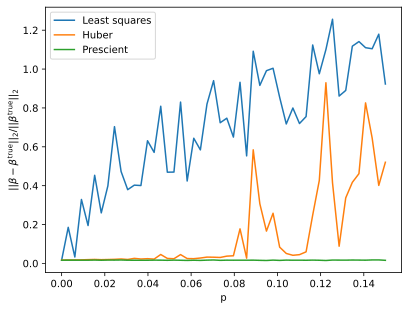

In [3]:
# Plot the relative reconstruction error for
# least-squares, prescient, and Huber regression.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

plt.plot(p_vals, lsq_data, label="Least squares")
plt.plot(p_vals, huber_data, label="Huber")
plt.plot(p_vals, prescient_data, label="Prescient")
plt.ylabel(r"$\||\beta - \beta^{\mathrm{true}}\||_2/\||\beta^{\mathrm{true}}\||_2$")
plt.xlabel("p")
plt.legend(loc="upper left")
plt.show()

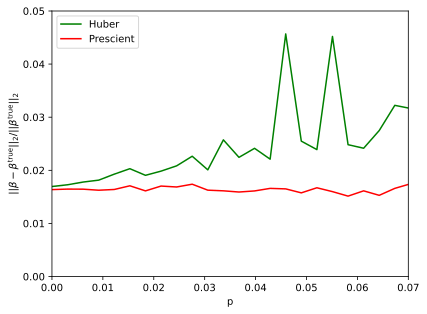

In [4]:
# Plot the relative reconstruction error for Huber and prescient regression,
# zooming in on smaller values of p.
indices = np.where(p_vals <= 0.08)

plt.plot(p_vals[indices], huber_data[indices], "g", label="Huber")
plt.plot(p_vals[indices], prescient_data[indices], "r", label="Prescient")
plt.ylabel(r"$\||\beta - \beta^{\mathrm{true}}\||_2/\||\beta^{\mathrm{true}}\||_2$")
plt.xlabel("p")
plt.xlim([0, 0.07])
plt.ylim([0, 0.05])
plt.legend(loc="upper left")
plt.show()